## Clutter a jak na to...

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
import io
from PIL import Image as PILImage
from IPython.display import Image as IPImage, display
import matplotlib.transforms as transforms
np.set_printoptions(precision=2)
from scipy.spatial.distance import mahalanobis

## Simulace

In [ ]:
def vytvor_simulaci(dt, q, r, x0, pocet_kroku=100):
    """
    Vytvoří simulaci pohybu objektu a měření pro Kalmanův filtr.

    Parametry:
    dt - časový krok
    q - hodnota šumu procesu
    r - hodnota šumu měření
    x0 - počáteční stav [x, y, vx, vy]
    pocet_kroku - počet kroků simulace

    Vrací:
    x - skutečné stavy
    z - měření
    A, H, Q, R - matice modelu
    """
    # Vytvoření matic modelu
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1,  0],
                  [0, 0, 0,  1]])
    Q = q**2 * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                      [0,       dt**3/3, 0,       dt**2/2],
                      [dt**2/2, 0,       dt,      0      ],
                      [0,       dt**2/2, 0,       dt     ]])
    H = np.array([[1., 0, 0, 0],
                  [0., 1, 0, 0]])
    R = r**2 * np.eye(2)

    # Generování dat
    np.random.seed(2)  # Pro reprodukovatelnost

    x = np.zeros((pocet_kroku, 4))
    x[0] = x0
    z = np.zeros((pocet_kroku, 2))
    z[0] = H @ x[0] + mvn.rvs(cov=R)

    for k in range(1, pocet_kroku):
        x[k] = A @ x[k-1] + mvn.rvs(cov=Q)
        z[k] = H @ x[k] + mvn.rvs(cov=R)

    return x, z, A, H, Q, R

def add_clutter_poisson(x, z, A, H, Q, R, dt, q, r, x0, pocet_kroku=100, clutter_lambda=5,
                         x_bounds=None, y_bounds=None):
    """
    Vytvoří simulaci pohybu objektu a měření pro Kalmanův filtr s přidáním clutteru.

    Parametry:
    dt - časový krok
    q - hodnota šumu procesu
    r - hodnota šumu měření
    x0 - počáteční stav [x, y, vx, vy]
    pocet_kroku - počet kroků simulace
    clutter_lambda - parametr Poissonova rozložení pro počet bodů clutteru
    x_bounds - hranice oblasti pro generování clutteru ve směru x [min, max]
    y_bounds - hranice oblasti pro generování clutteru ve směru y [min, max]

    Vrací:
    x - skutečné stavy
    z - čistá měření
    clutter - seznam bodů clutteru pro každý krok
    A, H, Q, R - matice modelu
    """

    """
    if x_bounds is None:
        margin = np.max(np.abs(z[:, 0])) * 0.75
        x_min = np.min(z[:, 0]) - margin
        x_max = np.max(z[:, 0]) + margin
        x_bounds = [x_min, x_max]

    if y_bounds is None:
        margin = np.max(np.abs(z[:, 1])) * 0.75
        y_min = np.min(z[:, 1]) - margin
        y_max = np.max(z[:, 1]) + margin
        y_bounds = [y_min, y_max]

    """

    margin = 10
    x_min, x_max = min(min(z[:,0]), min(x[:,0])) - margin, max(max(z[:,0]), max(x[:,0])) + margin
    y_min, y_max = min(min(z[:,1]), min(x[:,1])) - margin, max(max(z[:,1]), max(x[:,1])) + margin

    x_bounds = [x_min, x_max]
    y_bounds = [y_min, y_max]

    # Generování clutteru pro každý krok
    clutter = []
    np.random.seed(42)  # Pro reprodukovatelnost clutteru

    for k in range(pocet_kroku):
        # 1. Vzorkování počtu bodů z Poissonova rozdělení
        m = np.random.poisson(clutter_lambda)

        # 2. Vzorkování pozic bodů clutteru
        if m > 0:
            clutter_k = np.zeros((m, 2))
            clutter_k[:, 0] = np.random.uniform(x_bounds[0], x_bounds[1], m)
            clutter_k[:, 1] = np.random.uniform(y_bounds[0], y_bounds[1], m)
        else:
            clutter_k = np.zeros((0, 2))  # Prázdná matice pro případ m=0

        clutter.append(clutter_k)

    return clutter

## Additional

In [ ]:
def bod_v_elipse(bod, z_pred, kovariancni_matice, n_std=3.0):
    """
    Zjistí, zda bod leží uvnitř konfidenční elipsy definované kovarianční maticí.

    Parametry:
    bod - souřadnice bodu [x, y]
    stred - střed elipsy [x, y]
    kovariancni_matice - kovarianční matice 2x2
    n_std - násobek směrodatné odchylky pro elipsu

    Vrací:
    bool - True pokud bod leží v elipse, jinak False
    """
    # Vzdálenost bodu od středu v Mahalanobisově metrice
    rozdil = np.array(bod) - np.array(z_pred)
    maha_vzdalenost_sq = rozdil @ np.linalg.inv(kovariancni_matice) @ rozdil

    return maha_vzdalenost_sq <= n_std ** 2

def najdi_mereni_v_elipse(vsechna_mereni, z_pred, S, n_std=3.0):
    """
    Najde měření, která leží v konfidenční elipse.

    Parametry:
    vsechna_mereni - list všech měření pro daný krok
    stred_predikce - predikovaná poloha [x, y]
    S - inovační kovarianční matice
    n_std - násobek směrodatné odchylky pro elipsu

    Vrací:
    List měření, která leží v elipse
    """
    mereni_v_elipse = []

    for mereni in vsechna_mereni:
        if bod_v_elipse(mereni, z_pred, S, n_std):
            mereni_v_elipse.append(mereni)

    return mereni_v_elipse

def spocitej_pseudo_mereni(mereni_v_elipse):
    """
    Vypočítá pseudo-měření jako průměr měření v elipse.

    Parametry:
    mereni_v_elipse - list měření, která leží v elipse

    Vrací:
    pseudo_mereni - průměrný bod [x, y]
    """
    if not mereni_v_elipse:
        return None

    return np.mean(mereni_v_elipse, axis=0)

def vahy_mereni_v_elipse(vsechna_mereni, z_pred, S, gamma=9):
    """
    Vypočítá váhy měření nacházejících se v konfidenční elipse na základě normalizované Mahalanobisovy vzdálenosti.

    Parametry:
    vsechna_mereni - seznam měření (včetně clutteru)
    stred_predikce - predikovaná poloha (Hx_pred)
    S - inovační kovarianční matice

    Vrací:
    mereni_v_elipse - seznam měření v elipse
    vahy - seznam vah odpovídajících měřením
    """
    mereni_v_elipse = []
    vahy = []

    # Inverzní kovarianční matice (pro výpočet Mahalanobisovy vzdálenosti)
    S_inv = np.linalg.inv(S)

    # Seznam vzdáleností d^2 pro normalizaci vah
    vzdalenosti_sq = []

    for mereni in vsechna_mereni:
        # Rozdíl mezi měřením a predikcí
        rozdil = np.array(mereni) - np.array(z_pred)

        # Výpočet Mahalanobisovy vzdálenosti na druhou
        maha_vzdalenost_sq = rozdil @ S_inv @ rozdil

        # Pokud je měření v elipse (limit gamma = 9.0 odpovídá 3-sigma pro 2D)
        if maha_vzdalenost_sq <= gamma:
            mereni_v_elipse.append(mereni)
            vzdalenosti_sq.append(maha_vzdalenost_sq)

    if len(vzdalenosti_sq) > 0:
        vahy = [1 / (d2 + 1e-10) for d2 in vzdalenosti_sq]
        suma_vah = np.sum(vahy)
        vahy = [vaha / suma_vah for vaha in vahy]

    return mereni_v_elipse, vahy

def spocitej_vazene_mereni(mereni_v_elipse, vahy):
    """
    Vypočítá vážený průměr měření.

    Parametry:
    mereni_v_elipse - seznam měření v elipse
    vahy - váhy odpovídající měřením

    Vrací:
    vazene_mereni - vážený průměr [x, y]
    """

    if not mereni_v_elipse or len(mereni_v_elipse) == 0:
        return None

    # Převod na numpy array pro jednodušší výpočty
    mereni_array = np.array(mereni_v_elipse)
    vahy_array = np.array(vahy)

    # Výpočet váženého průměru
    vazene_mereni = np.sum(mereni_array * vahy_array[:, np.newaxis], axis=0) / np.sum(vahy_array)

    return vazene_mereni

## Kalman

In [ ]:
def kalman(z, A, H, Q, R, x_est, P, vypadek_mereni=None):
    """
    Spustí Kalmanův filtr s možností výpadku měření.

    Parametry:
    z - měření
    A, H, Q, R - matice modelu
    x_est - počáteční odhad stavu
    P - počáteční kovarianční matice
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření

    Vrací:
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    x_log = []
    P_log = []

    for t, zt in enumerate(z):
        # Predikční krok
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Pokud není výpadek měření, proveď aktualizační krok
        if t not in vypadek_mereni:
            # Aktualizační krok
            S = H @ P_pred @ H.T + R
            v = zt - H @ x_pred
            K = P_pred @ H.T @ np.linalg.inv(S)

            x_post = x_pred + K @ v
            P_post = (np.eye(4) - K @ H) @ P_pred
        else:
            # Při výpadku měření zůstáváme u predikce
            x_post = x_pred
            P_post = P_pred

        x_log.append(x_post.copy())
        P_log.append(P_post.copy())
        x_est = x_post
        P = P_post

    return np.array(x_log), np.array(P_log)


def kalman_clutter_mean(z, clutter, A, H, Q, R, x_est, P, vypadek_mereni=None, n_std=3.0):
    """
    Spustí Kalmanův filtr s možností zpracování clutteru.

    Parametry:
    z - originální měření (bez clutteru)
    clutter - seznam bodů clutteru pro každý krok
    A, H, Q, R - matice modelu
    x_est - počáteční odhad stavu
    P - počáteční kovarianční matice
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření
    n_std - násobek směrodatné odchylky pro konfidenční elipsu

    Vrací:
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    pseudo_mereni_log - historie vypočítaných pseudo-měření
    mereni_v_elipse_log - historie měření v elipse
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    x_log = []
    P_log = []
    pseudo_mereni_log = []
    mereni_v_elipse_log = []

    for t in range(len(z)):
        # Predikční krok
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Inovační kovarianční matice
        S = H @ P_pred @ H.T + R

        # Aktualizační krok s možností zpracování clutteru
        if t not in vypadek_mereni:
            # Sloučení originálního měření a clutteru
            vsechna_mereni = [z[t]]
            if len(clutter[t]) > 0:
                for clutter_bod in clutter[t]:
                    vsechna_mereni.append(clutter_bod)

            # Najdeme měření, která leží v konfidenční elipse
            z_pred = H @ x_pred
            mereni_v_elipse = najdi_mereni_v_elipse(vsechna_mereni, z_pred, S, n_std)

            # Výpočet pseudo-měření jako průměru měření v elipse
            pseudo_mereni = spocitej_pseudo_mereni(mereni_v_elipse)

            # Pokud máme pseudo-měření, použijeme ho pro aktualizaci
            if pseudo_mereni is not None:
                v = pseudo_mereni - H @ x_pred
                K = P_pred @ H.T @ np.linalg.inv(S)
                x_post = x_pred + K @ v
                P_post = (np.eye(4) - K @ H) @ P_pred
            else:
                # Pokud nemáme žádná měření v elipse, použijeme jen predikci
                x_post = x_pred
                P_post = P_pred
                pseudo_mereni = None
                mereni_v_elipse = []
        else:
            # Při výpadku měření zůstáváme u predikce
            x_post = x_pred
            P_post = P_pred
            pseudo_mereni = None
            mereni_v_elipse = []

        x_log.append(x_post.copy())
        P_log.append(P_post.copy())
        pseudo_mereni_log.append(pseudo_mereni)
        mereni_v_elipse_log.append(mereni_v_elipse)

        x_est = x_post
        P = P_post

    return np.array(x_log), np.array(P_log), pseudo_mereni_log, mereni_v_elipse_log


def kalman_weighed_clutter(z, clutter, A, H, Q, R, x_est, P, vypadek_mereni=None, gamma=9.0):
    """
    Spustí vylepšený Kalmanův filtr s váženým průměrováním měření.

    Parametry:
    z - originální měření (bez clutteru)
    clutter - seznam bodů clutteru pro každý krok
    A, H, Q, R - matice modelu
    x_est - počáteční odhad stavu
    P - počáteční kovarianční matice
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření
    gamma - parametr pro určení velikosti konfidenční elipsy (9.0 = 3-sigma pro 2D)

    Vrací:
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    vazene_mereni_log - historie vypočítaných vážených průměrů měření
    mereni_v_elipse_log - historie měření v elipse
    vahy_log - historie vah pro každé měření
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    x_log = []
    P_log = []
    vazene_mereni_log = []
    mereni_v_elipse_log = []
    vahy_log = []

    for t in range(len(z)):
        # Predikční krok
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Inovační kovarianční matice
        S = H @ P_pred @ H.T + R

        # Aktualizační krok s možností zpracování clutteru
        if t not in vypadek_mereni:
            # Sloučení originálního měření a clutteru
            vsechna_mereni = [z[t]]
            if len(clutter[t]) > 0:
                for clutter_bod in clutter[t]:
                    vsechna_mereni.append(clutter_bod)

            # Najdeme měření v elipse a jejich váhy
            stred_predikce = H @ x_pred
            mereni_v_elipse, vahy = vahy_mereni_v_elipse(vsechna_mereni, stred_predikce, S, gamma)

            # Якщо є лише одне вимірювання в еліпсі, пропускаємо ваги і відразу виконуємо апдейт
            if len(mereni_v_elipse) == 1:
                vazene_mereni = mereni_v_elipse[0]
                v = vazene_mereni - H @ x_pred
                K = P_pred @ H.T @ np.linalg.inv(S)
                x_post = x_pred + K @ v
                P_post = (np.eye(4) - K @ H) @ P_pred
            else:
                # Výpočet váženého průměru měření
                vazene_mereni = spocitej_vazene_mereni(mereni_v_elipse, vahy)

                # Pokud máme vážené měření, použijeme ho pro aktualizaci
                if vazene_mereni is not None:
                    v = vazene_mereni - H @ x_pred
                    K = P_pred @ H.T @ np.linalg.inv(S)
                    x_post = x_pred + K @ v
                    P_post = (np.eye(4) - K @ H) @ P_pred
                else:
                    # Pokud nemáme žádná měření v elipse, použijeme jen predikci
                    x_post = x_pred
                    P_post = P_pred
                    vazene_mereni = None
                    mereni_v_elipse = []
                    vahy = []
        else:
            # Při výpadku měření zůstáváme u predikce
            x_post = x_pred
            P_post = P_pred
            vazene_mereni = None
            mereni_v_elipse = []
            vahy = []

        x_log.append(x_post.copy())
        P_log.append(P_post.copy())
        vazene_mereni_log.append(vazene_mereni)
        mereni_v_elipse_log.append(mereni_v_elipse)
        vahy_log.append(vahy)

        x_est = x_post
        P = P_post

    return np.array(x_log), np.array(P_log), vazene_mereni_log, mereni_v_elipse_log, vahy_log

def kalman_nearest_mahalanobis(z, clutter, A, H, Q, R, x_est, P, vypadek_mereni=None, gamma=9.0):
    """
    Kalmanův filtr, který vybírá nejbližší měření pomocí Mahalanobisovy vzdálenosti.

    Parametry:
    z - originální měření (bez clutteru)
    clutter - seznam bodů clutteru pro každý krok
    A, H, Q, R - matice modelu
    x_est - počáteční odhad stavu
    P - počáteční kovarianční matice
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření
    gamma - maximální přijatelná Mahalanobisova vzdálenost (9.0 = 3-sigma oblast)

    Vrací:
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    vybrana_mereni_log - historie vybraných měření
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    x_log = []
    P_log = []
    vybrana_mereni_log = []
    mereni_v_elipse_log = []

    for t in range(len(z)):
        # Predikční krok
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Inovační kovarianční matice
        S = H @ P_pred @ H.T + R
        S_inv = np.linalg.inv(S)

        # Pokud je výpadek měření, provádíme pouze predikci
        if t in vypadek_mereni:
            x_post = x_pred
            P_post = P_pred
            vybrane_mereni = None
        else:
            # Kombinujeme reálná měření a clutter
            vsechna_mereni = [z[t]] + list(clutter[t])

            # Výpočet Mahalanobisovy vzdálenosti pro každé měření
            d_squared = [mahalanobis(m, H @ x_pred, S_inv) ** 2 for m in vsechna_mereni]

            # Filtrujeme měření uvnitř elipsy (d^2 <= gamma)
            prijata_mereni = [m for i, m in enumerate(vsechna_mereni) if d_squared[i] <= gamma]

            if len(prijata_mereni) > 0:
                # Najdeme měření s nejmenší vzdáleností
                idx_min = np.argmin([d_squared[i] for i in range(len(vsechna_mereni)) if d_squared[i] <= gamma])
                vybrane_mereni = prijata_mereni[idx_min]

                # Inovace
                v = vybrane_mereni - H @ x_pred
                K = P_pred @ H.T @ S_inv
                x_post = x_pred + K @ v
                P_post = (np.eye(len(P)) - K @ H) @ P_pred
            else:
                # Pokud žádné měření nespadá do elipsy, ponecháme predikci
                x_post = x_pred
                P_post = P_pred
                vybrane_mereni = None

        # Uložíme výsledky
        x_log.append(x_post.copy())
        P_log.append(P_post.copy())
        vybrana_mereni_log.append(vybrane_mereni)
        mereni_v_elipse_log.append(prijata_mereni)

        # Aktualizujeme odhad pro další iteraci
        x_est = x_post
        P = P_post

    return np.array(x_log), np.array(P_log), vybrana_mereni_log, mereni_v_elipse_log


## Vizualizace

In [ ]:
def confidence_ellipse(loc, cov, ax, n_std=3.0, facecolor='none', **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = loc[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = loc[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
def simple_animation(z, x, x_log, P_log, nazev_souboru="kalman_trajektorie.gif", fps=10, vypadek_mereni=None):
    """
    Vytvoří animaci trajektorie Kalmanova filtru.

    Parametry:
    z - měření
    x - skutečné stavy
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    nazev_souboru - název výstupního GIF souboru
    fps - snímky za sekundu
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření

    Vrací:
    IPImage objekt s animací
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    fig, ax = plt.subplots(figsize=(10, 8))

    # Určení rozsahu os
    margin = 40
    x_min, x_max = min(min(z[:,0]), min(x[:,0])) - margin, max(max(z[:,0]), max(x[:,0])) + margin
    y_min, y_max = min(min(z[:,1]), min(x[:,1])) - margin, max(max(z[:,1]), max(x[:,1])) + margin

    def update(frame):
        ax.clear()

        # Nastavení rozsahu os
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Kreslení celé trajektorie měření a skutečné trajektorie (jako průsvitné)
        ax.plot(z[:, 0], z[:, 1], '.', color='blue', alpha=0.3, label='Měření')
        ax.plot(x[:, 0], x[:, 1], '-', color='red', alpha=0.3, label='Skutečná trajektorie')

        # Kreslení historie dosud odhadnuté trajektorie
        ax.plot(x_log[:frame+1, 0], x_log[:frame+1, 1], '-', color='green', label='Odhadnutá trajektorie')

        # Kreslení aktuálního měření a odhadu
        if frame < len(z):
            if frame not in vypadek_mereni:
                ax.plot(z[frame, 0], z[frame, 1], 'o', color='blue', markersize=8)
            else:
                ax.text(0.02, 0.98, 'Výpadek měření!', transform=ax.transAxes, color='red', fontsize=12,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Kreslení aktuálního odhadu s elipsou nejistoty
        if frame < len(x_log):
            ax.plot(x_log[frame, 0], x_log[frame, 1], 'o', color='green', markersize=8)

            # Vytvoření elipsy kovariační matice (jen pro pozici, tj. první 2x2 submatice)
            covariance = P_log[frame][:2, :2]
            eigenvalues, eigenvectors = np.linalg.eig(covariance)

            # Velikost elipsy - 3 sigma (99.7% interval spolehlivosti)
            width, height = 2 * 3 * np.sqrt(eigenvalues)

            # Úhel elipsy
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

            # Vykreslení elipsy
            ellipse = Ellipse(xy=(x_log[frame, 0], x_log[frame, 1]),
                             width=width, height=height,
                             angle=angle, edgecolor='green', fc='none',
                             lw=2, alpha=0.5)
            ax.add_patch(ellipse)

        # Přidání informačního textu
        if frame < len(x_log):
            info_text = f"Čas: {frame}\n"
            info_text += f"Pozice: ({x_log[frame, 0]:.2f}, {x_log[frame, 1]:.2f})\n"
            info_text += f"Rychlost: ({x_log[frame, 2]:.2f}, {x_log[frame, 3]:.2f})"

            ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title('Animace trajektorie Kalmanova filtru')
        ax.grid(True)
        ax.legend(loc='upper right')

        return ax

    # Vytvoření animace
    ani = animation.FuncAnimation(fig, update, frames=len(z), interval=1000/fps, blit=False)

    # Uložení do GIF
    ani.save(nazev_souboru, writer='pillow', fps=fps)

    plt.close(fig)

    # Zobrazení vytvořeného GIFu
    print(f"Animace trajektorie byla uložena do souboru {nazev_souboru}")
    with open(nazev_souboru, 'rb') as f:
        return IPImage(data=f.read())

In [ ]:
def animace_kalman_s_clutterem(z, clutter, x, x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log,
                                    nazev_souboru="kalman_clutter.gif", fps=5, vypadek_mereni=None,
                                    lambda_value=None):
    """
    Vytvoří animaci trajektorie Kalmanova filtru s clutterem.

    Parametry:
    z - originální měření
    clutter - seznam bodů clutteru pro každý krok
    x - skutečné stavy
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    pseudo_mereni_log - historie vypočítaných pseudo-měření
    mereni_v_elipse_log - historie měření v elipse
    nazev_souboru - název výstupního GIF souboru
    fps - snímky za sekundu
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření
    lambda_value - hodnota lambda pro zobrazení v titulku
    method - textový řetězec popisující metodu, která se zobrazí v titulku

    Vrací:
    IPImage objekt s animací
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    fig, ax = plt.subplots(figsize=(12, 10))

    # Určení rozsahu os
    # Shromáždíme všechny body pro určení rozsahu
    all_x = []
    all_y = []

    all_x.extend(z[:, 0])
    all_y.extend(z[:, 1])
    all_x.extend(x[:, 0])
    all_y.extend(x[:, 1])

    for c in clutter:
        if len(c) > 0:
            all_x.extend(c[:, 0])
            all_y.extend(c[:, 1])

    margin = 40
    x_min, x_max = min(all_x) - margin, max(all_x) + margin
    y_min, y_max = min(all_y) - margin, max(all_y) + margin

    def update(frame):
        ax.clear()

        # Nastavení rozsahu os
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Kreslení celé trajektorie měření a skutečné trajektorie (jako průsvitné)
        ax.plot(z[:, 0], z[:, 1], '.', color='blue', alpha=0.3, label='Pravá měření')
        ax.plot(x[:, 0], x[:, 1], '-', color='red', alpha=0.3, label='Skutečná trajektorie')

        # Kreslení historie dosud odhadnuté trajektorie
        ax.plot(x_log[:frame+1, 0], x_log[:frame+1, 1], '-', color='green', label='Odhadnutá trajektorie')

        # Kreslení clutteru pro aktuální snímek
        if frame < len(clutter) and len(clutter[frame]) > 0:
            ax.plot(clutter[frame][:, 0], clutter[frame][:, 1], 'kx', markersize=8, label='Clutter')

        # Kreslení originálního měření pro aktuální snímek
        if frame < len(z) and frame not in vypadek_mereni:
            ax.plot(z[frame, 0], z[frame, 1], 'o', color='blue', markersize=8, label='Aktuální měření')

        # Kreslení měření, která byla vybrána do elipsy
        if frame < len(mereni_v_elipse_log) and mereni_v_elipse_log[frame]:
            for mereni in mereni_v_elipse_log[frame]:
                ax.plot(mereni[0], mereni[1], 'ko', fillstyle='none', markersize=12)

            # Kreslení pseudo-měření
            if len(mereni_v_elipse_log[frame]) > 1 and pseudo_mereni_log[frame] is not None:
                ax.plot(pseudo_mereni_log[frame][0], pseudo_mereni_log[frame][1], 'rx', markersize=10,
                       label='Pseudo-měření')

        # Kreslení aktuálního odhadu s elipsou nejistoty
        if frame < len(x_log):
            ax.plot(x_log[frame, 0], x_log[frame, 1], 'o', color='green', markersize=8,
                   label='Aktuální odhad')

            # Vytvoření elipsy kovariační matice (jen pro pozici, tj. první 2x2 submatice)
            covariance = P_log[frame][:2, :2]

            # Kontrola, zda kovarianční matice není singulární
            if np.linalg.det(covariance) > 1e-10:
            # Použití vlastní funkce pro vykreslení elipsy
              confidence_ellipse(
                loc=(x_log[frame, 0], x_log[frame, 1]),
                cov=covariance,
                ax=ax,
                n_std=3.0,
                edgecolor='green',
                lw=2,
               alpha=0.5
                  )

        # Přidání informačního textu
        if frame < len(x_log):
            info_text = f"Čas: {frame}\n"
            if frame in vypadek_mereni:
                info_text += "VÝPADEK MĚŘENÍ!\n"

            count_in_ellipse = len(mereni_v_elipse_log[frame]) if frame < len(mereni_v_elipse_log) else 0
            info_text += f"Počet měření v elipse: {count_in_ellipse}\n"

            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Nastavení titulku s hodnotou lambda a metodou
        title = 'Animace Kalmanova filtru s clutterem'
        if lambda_value is not None:
            title += f", λ = {lambda_value}"
        title += f"\n Mean-clutter method"
        ax.set_title(title, fontsize=14)

        ax.grid(True)

        # Vytvoření legendy s unikátními položkami
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        return ax

    # Vytvoření animace
    ani = animation.FuncAnimation(fig, update, frames=len(z), interval=1000/fps, blit=False)

    # Uložení do GIF
    ani.save(nazev_souboru, writer='pillow', fps=fps)

    plt.close(fig)

    # Zobrazení vytvořeného GIFu
    print(f"Animace trajektorie byla uložena do souboru {nazev_souboru}")
    with open(nazev_souboru, 'rb') as f:
        return IPImage(data=f.read())

In [ ]:
def animace_weighed_clutter(z, clutter, x, x_log, P_log, vazene_mereni_log, mereni_v_elipse_log, vahy_log,
                             nazev_souboru="kalman_vah_clutter.gif", fps=5, vypadek_mereni=None, lambda_value=None, gamma = 2):
    """
    Vytvoří animaci trajektorie vylepšeného Kalmanova filtru s váženým průměrováním.

    Parametry:
    z - originální měření
    clutter - seznam bodů clutteru pro každý krok
    x - skutečné stavy
    x_log - historie odhadů stavu
    P_log - historie kovariančních matic
    vazene_mereni_log - historie vypočítaných vážených průměrů měření
    mereni_v_elipse_log - historie měření v elipse
    vahy_log - historie vah pro každé měření
    nazev_souboru - název výstupního GIF souboru
    fps - snímky za sekundu
    vypadek_mereni - seznam indexů, kde dochází k výpadku měření

    Vrací:
    IPImage objekt s animací
    """
    if vypadek_mereni is None:
        vypadek_mereni = []

    fig, ax = plt.subplots(figsize=(12, 10))

    # Určení rozsahu os
    # Shromáždíme všechny body pro určení rozsahu
    all_x = []
    all_y = []

    all_x.extend(z[:, 0])
    all_y.extend(z[:, 1])
    all_x.extend(x[:, 0])
    all_y.extend(x[:, 1])

    for c in clutter:
        if len(c) > 0:
            all_x.extend(c[:, 0])
            all_y.extend(c[:, 1])

    margin = 60
    x_min, x_max = min(all_x) - margin, max(all_x) + margin
    y_min, y_max = min(all_y) - margin, max(all_y) + margin

    def update(frame):
        ax.clear()

        # Nastavení rozsahu os
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Kreslení celé trajektorie měření a skutečné trajektorie (jako průsvitné)
        ax.plot(z[:, 0], z[:, 1], '.', color='blue', alpha=0.3, label='Pravá měření')
        ax.plot(x[:, 0], x[:, 1], '-', color='red', alpha=0.3, label='Skutečná trajektorie')

        # Kreslení historie dosud odhadnuté trajektorie
        ax.plot(x_log[:frame+1, 0], x_log[:frame+1, 1], '-', color='green', label='Odhadnutá trajektorie')

        # Kreslení clutteru pro aktuální snímek
        if frame < len(clutter) and len(clutter[frame]) > 0:
            ax.plot(clutter[frame][:, 0], clutter[frame][:, 1], 'kx', markersize=8, label='Clutter')

        # Kreslení měření, která byla vybrána do elipsy
        if frame < len(mereni_v_elipse_log) and mereni_v_elipse_log[frame]:
            for mereni in mereni_v_elipse_log[frame]:
                ax.plot(mereni[0], mereni[1], 'ko', fillstyle='none', markersize=12)

            # Kreslení pseudo-měření
            if len(mereni_v_elipse_log[frame]) > 1 and pseudo_mereni_log[frame] is not None:
                ax.plot(pseudo_mereni_log[frame][0], pseudo_mereni_log[frame][1], 'rx', markersize=10,
                       label='Pseudo-měření')

        # Kreslení originálního měření pro aktuální snímek
        if frame < len(z) and frame not in vypadek_mereni:
            ax.plot(z[frame, 0], z[frame, 1], 'o', color='blue', markersize=8, label='Aktuální měření')

        # Kreslení aktuálního odhadu s elipsou nejistoty
        if frame < len(x_log):
            ax.plot(x_log[frame, 0], x_log[frame, 1], 'o', color='green', markersize=8,
                   label='Aktuální odhad')

            # Vytvoření elipsy kovariační matice (jen pro pozici, tj. první 2x2 submatice)
            covariance = P_log[frame][:2, :2]

            # Kontrola, zda kovarianční matice není singulární
            if np.linalg.det(covariance) > 1e-10:
            # Použití vlastní funkce pro vykreslení elipsy
              confidence_ellipse(
                loc=(x_log[frame, 0], x_log[frame, 1]),
                cov=covariance,
                ax=ax,
                n_std=3.0,
                edgecolor='green',
                lw=2,
               alpha=0.5
                  )

        # Přidání informačního textu
        if frame < len(x_log):
            info_text = f"Čas: {frame}\n"
            if frame in vypadek_mereni:
                info_text += "VÝPADEK MĚŘENÍ!\n"

            count_in_ellipse = len(mereni_v_elipse_log[frame]) if frame < len(mereni_v_elipse_log) else 0
            info_text += f"Počet měření v elipse: {count_in_ellipse}\n"

            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Nastavení titulku s hodnotou lambda a metodou
        title = 'Animace Kalmanova filtru s clutterem'
        if lambda_value is not None:
            title += f", λ = {lambda_value}"

        if gamma is not None:
            title += f", γ = {gamma}"

        title += f"\n Weighed-clutter method"
        ax.set_title(title, fontsize=14)

        ax.grid(True)

        # Vytvoření legendy s unikátními položkami
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        return ax

    # Vytvoření animace
    ani = animation.FuncAnimation(fig, update, frames=len(z), interval=1000/fps, blit=False)

    # Uložení do GIF
    ani.save(nazev_souboru, writer='pillow', fps=fps)

    plt.close(fig)

    # Zobrazení vytvořeného GIFu
    print(f"Animace trajektorie byla uložena do souboru {nazev_souboru}")
    with open(nazev_souboru, 'rb') as f:
        return IPImage(data=f.read())

## Experiment

In [ ]:
def ukazka_pouziti(vypadek_start=40, vypadek_konec=50, x0 = np.array([0., 0., 0., 0.]), x_est=np.array([0., 0., 1., 1.]), P=np.diag([100, 100, 100, 100]), dt=1, q=np.sqrt(0.5), r=5, nazev_souboru1 = "kalman_trajektorie.gif", nazev_souboru2 = "kalman_stavy.gif"):
    """
    Ukázka použití funkcí pro animaci Kalmanova filtru.

    Parametry:
    vypadek_start - začátek výpadku měření
    vypadek_konec - konec výpadku měření
    x_est - počáteční odhad stavu (výchozí [0, 0, 1, 1])
    P - počáteční kovarianční matice (výchozí diag([100, 100, 100, 100]))
    dt - časový krok
    q - intenzita šumu procesu
    r - intenzita šumu měření

    Vrací:
    animace trajektorie a stavů
    """


    x, z, A, H, Q, R = vytvor_simulaci(dt, q, r, x0)

    # Seznam indexů s výpadkem měření
    vypadek_mereni = list(range(vypadek_start, vypadek_konec + 1)) if vypadek_start >= 0 else []

    # Spuštění Kalmanova filtru
    x_log, P_log = kalman(z, A, H, Q, R, x_est, P, vypadek_mereni)

    # Vytvoření animací
    anim_trajektorie = simple_animation(z, x, x_log, P_log,
                                               nazev_souboru=nazev_souboru1,
                                               vypadek_mereni=vypadek_mereni)

    #anim_stavy = vytvor_animaci_stavu(z, x, x_log, P_log, nazev_souboru=nazev_souboru2, vypadek_mereni=vypadek_mereni)

    return anim_trajektorie

In [ ]:
def see_kalman_with_clutter(x0 = np.array([0., 0., 1., 1.]), x_est = np.array([0., 0., 1.5, 0.5]), P = np.diag([10, 10, 10, 10]), dt=1, q=np.sqrt(0.5), r=5, pocet_kroku=100, lambda_value=10, gamma = 2,
                          vypadek_start=40, vypadek_konec=50, n_std=3.0, fps=5,
                          nazev_souboru="kalman_clutter_animace.gif", metoda="mean"):
    """
    Ukázka použití Kalmanova filtru s clutterem.

    Parametry:
    dt - časový krok
    q - hodnota šumu procesu
    r - hodnota šumu měření
    pocet_kroku - počet kroků simulace
    clutter_lambda - průměrný počet bodů clutteru na krok
    vypadek_start - začátek výpadku měření
    vypadek_konec - konec výpadku měření
    n_std - násobek směrodatné odchylky pro konfidenční elipsu
    nazev_souboru - název výstupního GIF souboru
    metoda - metoda kalmana: clutter_mean, weighed_clutter,

    Vrací:
    IPImage objekt s animací
    """

    # Vytvoření simulace s clutterem
    x, z, clutter, A, H, Q, R = simulace_s_clutterem_poisson(dt, q, r, x0, pocet_kroku, lambda_value)

    # Seznam indexů s výpadkem měření
    vypadek_mereni = list(range(vypadek_start, vypadek_konec + 1)) if vypadek_start >= 0 else []

    # Inicializace logů
    x_log = []
    P_log = []
    pseudo_mereni_log = []
    mereni_v_elipse_log = []

    # Volba metody
    if metoda == "clutter_mean":
        x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log = kalman_clutter_mean(
            z, clutter, A, H, Q, R, x_est, P, vypadek_mereni, n_std
        )

        animace = animace_kalman_s_clutterem(z, clutter, x, x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log,
                                    nazev_souboru, fps, vypadek_mereni,
                                    lambda_value)

    elif metoda == "clutter_weighed":
        x_log, P_log, vazene_mereni_log, mereni_v_elipse_log, vahy_log = kalman_weighed_clutter(z, clutter, A, H, Q, R, x_est, P, vypadek_mereni, gamma)
        animace = animace_weighed_clutter(z, clutter, x, x_log, P_log, vazene_mereni_log, mereni_v_elipse_log, vahy_log,
                             nazev_souboru, fps, vypadek_mereni, lambda_value)

    else:
        raise ValueError("Neznámá metoda")

    return animace

# Results

In [ ]:
x0 = np.array([0., 0., 1., 1.])
x_est = np.array([0., 0., 1.5, 0.5])
P = np.diag([10, 10, 10, 10])
dt=1
q=np.sqrt(0.5)
r=5
pocet_kroku=100
lambda_value=12
gamma = 9
vypadek_start=40
vypadek_konec=50
n_std=3.0
fps=3

## Simple Kalman

In [ ]:
x, z, A, H, Q, R = vytvor_simulaci(dt, q, r, x0, pocet_kroku)

In [ ]:
vypadek_mereni = list(range(vypadek_start, vypadek_konec + 1)) if vypadek_start >= 0 else []

# Spuštění Kalmanova filtru
x_log, P_log = kalman(z, A, H, Q, R, x_est, P, vypadek_mereni)

Animace trajektorie byla uložena do souboru origina_kalman.gif


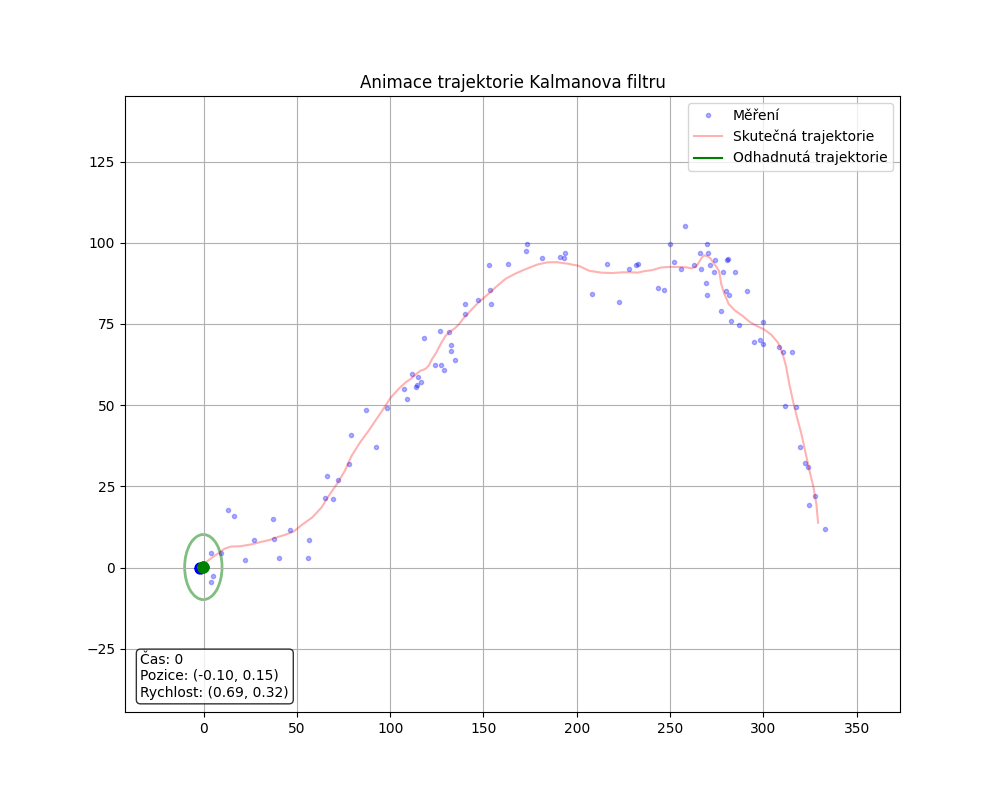

In [ ]:
# Vytvoření animací
anim_trajektorie = simple_animation(z, x, x_log, P_log,
                                               nazev_souboru="origina_kalman.gif",
                                               vypadek_mereni=vypadek_mereni)

anim_trajektorie

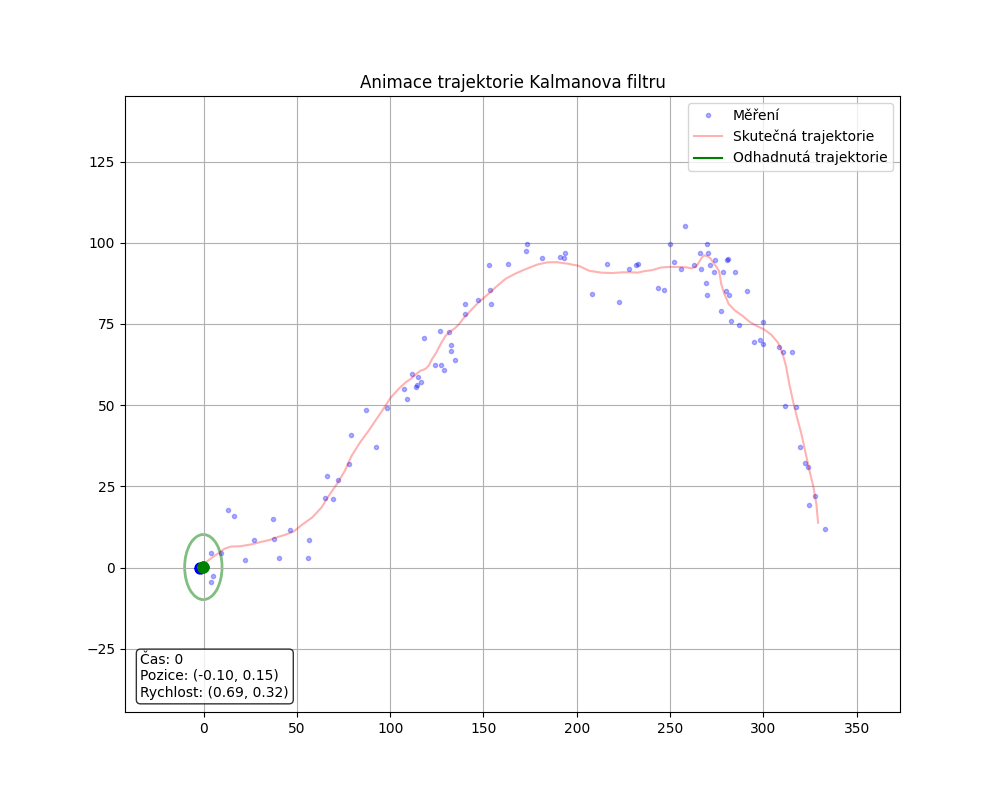

In [ ]:
anim_trajektorie

## Kalman with Clutter

In [ ]:
lambda_value=15
clutter = add_clutter_poisson(x, z, A, H, Q, R, dt, q, r, x0, pocet_kroku, clutter_lambda=lambda_value,
                         x_bounds=None, y_bounds=None)
# Seznam indexů s výpadkem měření
vypadek_mereni = list(range(vypadek_start, vypadek_konec + 1)) if vypadek_start >= 0 else []

# Inicializace logů
x_log = []
P_log = []
pseudo_mereni_log = []
mereni_v_elipse_log = []

### clutter_mean

In [ ]:
"""animace_1 = see_kalman_with_clutter(
    dt=1,
    q=np.sqrt(0.5),
    r=5,
    pocet_kroku=100,
    lambda_value=10,
    gamma = 2,
    vypadek_start=40,
    vypadek_konec=50,
    n_std=3.0,
    nazev_souboru="kalman_clutter_mean.gif",
    metoda="clutter_mean"
)

animace_1"""

'animace_1 = see_kalman_with_clutter(\n    dt=1,                \n    q=np.sqrt(0.5),        \n    r=5,                   \n    pocet_kroku=100,       \n    lambda_value=10, \n    gamma = 2,    \n    vypadek_start=40,      \n    vypadek_konec=50,      \n    n_std=3.0,            \n    nazev_souboru="kalman_clutter_mean.gif",\n    metoda="clutter_mean" \n)\n\nanimace_1'

Animace trajektorie byla uložena do souboru kalman_clutter_mean.gif


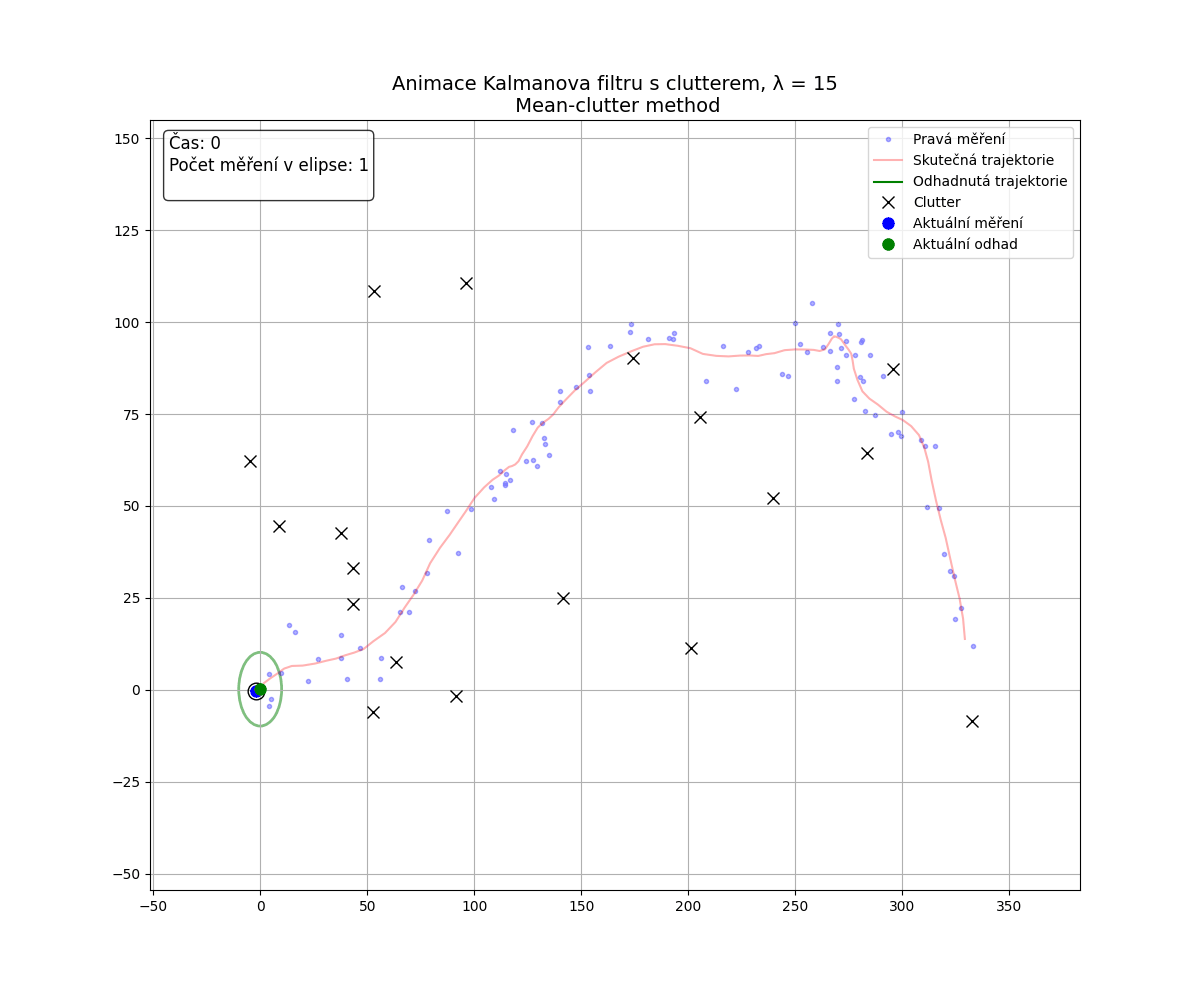

In [ ]:
metoda = "clutter_mean"
nazev_souboru="kalman_clutter_mean.gif"
x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log = kalman_clutter_mean(
            z, clutter, A, H, Q, R, x_est, P, vypadek_mereni, n_std
        )

animace_1 = animace_kalman_s_clutterem(z, clutter, x, x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log,
                                    nazev_souboru, fps, vypadek_mereni,
                                    lambda_value)

animace_1

### clutter_weighed

In [ ]:
"""animace_2 = see_kalman_with_clutter(
    dt=1,
    q=np.sqrt(0.5),
    r=5,
    pocet_kroku=100,
    lambda_value=10,
    gamma = 2,
    vypadek_start=40,
    vypadek_konec=50,
    n_std=3.0,
    nazev_souboru="kalman_clutter_weighed.gif",
    metoda="clutter_weighed"
)

animace_2"""

'animace_2 = see_kalman_with_clutter(\n    dt=1,                \n    q=np.sqrt(0.5),        \n    r=5,                   \n    pocet_kroku=100,       \n    lambda_value=10, \n    gamma = 2,    \n    vypadek_start=40,      \n    vypadek_konec=50,      \n    n_std=3.0,            \n    nazev_souboru="kalman_clutter_weighed.gif",\n    metoda="clutter_weighed" \n)\n\nanimace_2'

Animace trajektorie byla uložena do souboru kalman_clutter_weighed.gif


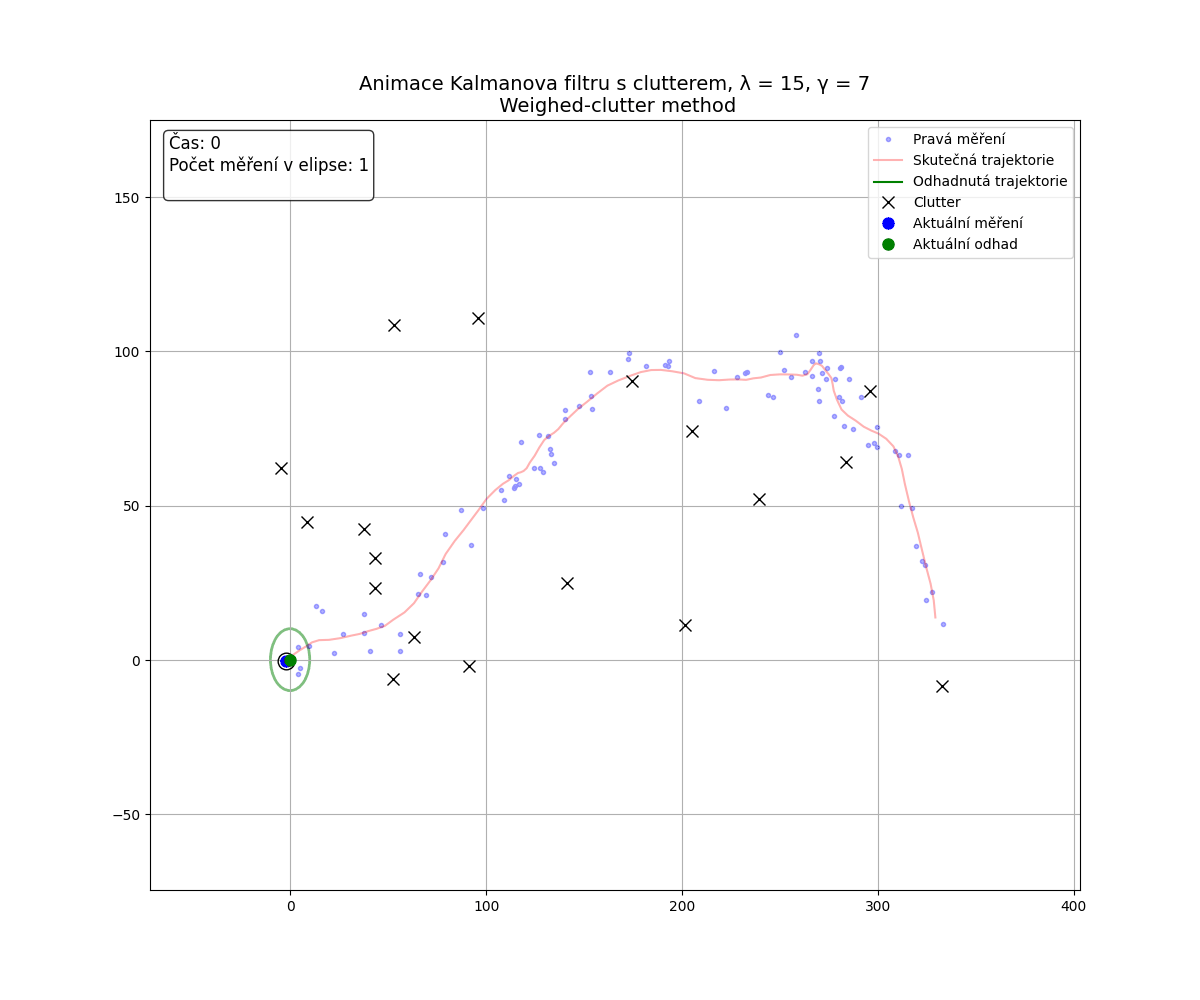

In [ ]:
metoda = "clutter_weighed"
nazev_souboru="kalman_clutter_weighed.gif"
gamma=7

x_log, P_log, vazene_mereni_log, mereni_v_elipse_log, vahy_log = kalman_weighed_clutter(z, clutter, A, H, Q, R, x_est, P, vypadek_mereni, gamma)

animace_2 = animace_weighed_clutter(z, clutter, x, x_log, P_log, vazene_mereni_log, mereni_v_elipse_log, vahy_log,
                             nazev_souboru, fps, vypadek_mereni, lambda_value, gamma)

animace_2

### clutter_nearest

Animace trajektorie byla uložena do souboru kalman_clutter_nearest.gif


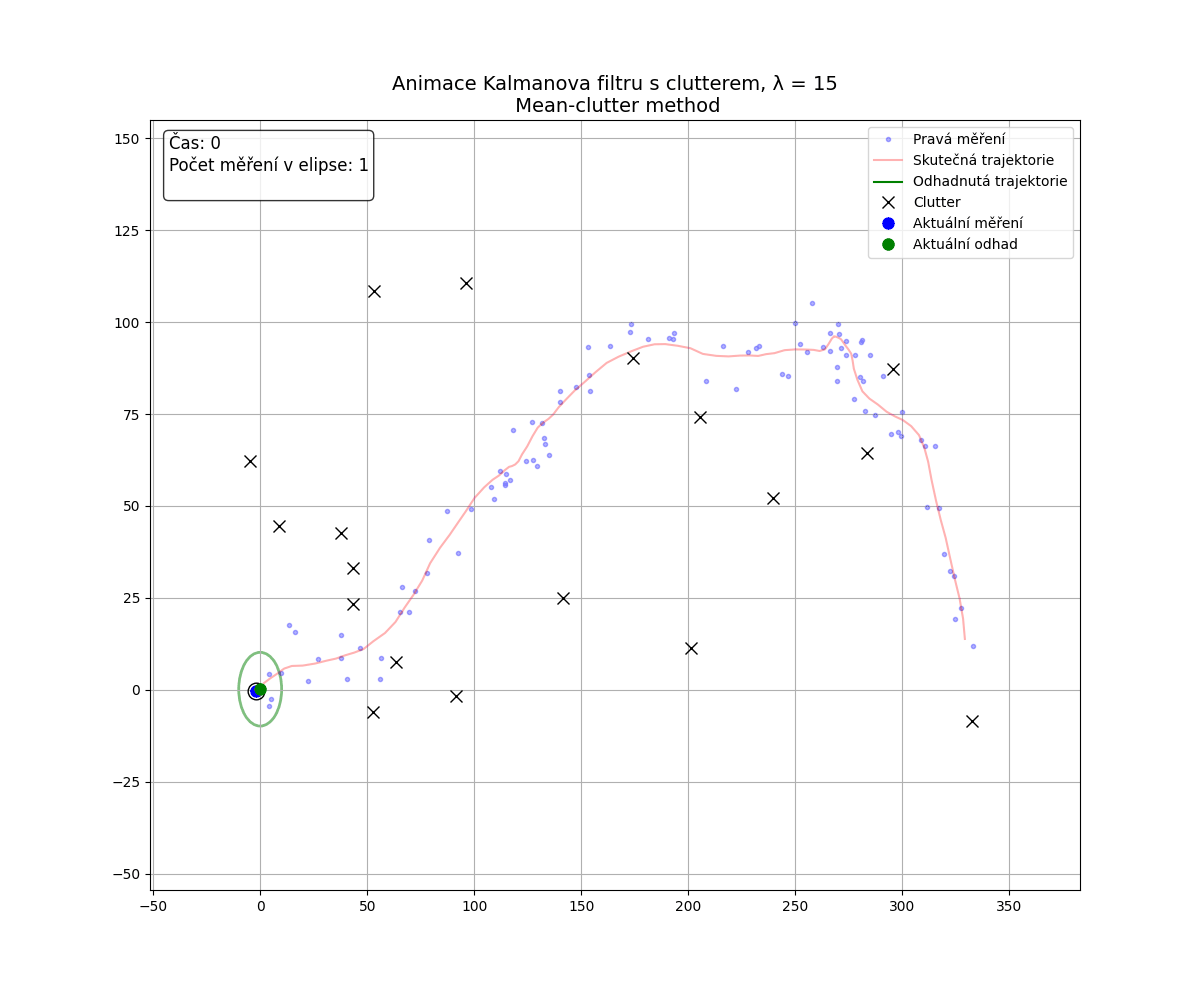

In [ ]:
metoda = "clutter_nearest"
nazev_souboru="kalman_clutter_nearest.gif"

gamma=9

x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log = kalman_nearest_mahalanobis(
            z, clutter, A, H, Q, R, x_est, P, vypadek_mereni, n_std)

animace_3 = animace_kalman_s_clutterem(z, clutter, x, x_log, P_log, pseudo_mereni_log, mereni_v_elipse_log,
                                    nazev_souboru, fps, vypadek_mereni,
                                    lambda_value)

animace_3